In [1]:
import os
os.environ.setdefault("XLA_FLAGS", "--xla_gpu_autotune_level=0")

'--xla_gpu_autotune_level=0'

In [2]:
import jax

jax.config.update("jax_default_matmul_precision", "float32")
jax.config.update("jax_compilation_cache_dir", "jax_xla_cache")
jax.config.update("jax_persistent_cache_min_entry_size_bytes", -1)
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)
jax.config.update("jax_persistent_cache_enable_xla_caches", "xla_gpu_per_fusion_autotune_cache_dir")

In [3]:
import rioxarray
import xarray
import pandas

import jax.numpy as jnp
import glaunti.ti_model as model
import dataloader.dataloader as dataloader
import core.loss as loss
import core.training as training
import utils.serialise
import utils.logger
import constants

import matplotlib.pyplot as plt
import datetime
import numpy as np
import pyproj
from tqdm import tqdm

In [4]:
dataset_index = dataloader.retrieve_dataset_index()
glacier = dataset_index[dataset_index.name == "Rembesdalskaaka"].iloc[0]

In [5]:
model_callable = jax.jit(
    jax.remat(
        lambda trainable_params, static_params, x, initial_swe: model.run_model(
            trainable_params, 
            static_params, 
            x, 
            initial_swe=initial_swe, 
            return_series=True, 
        ),
    ),
)
params = model.get_initial_model_parameters()
params = utils.serialise.load_pytree(f"params/a_finetuned_{glacier['name']}.eqx", template=params)
trainable_params, static_params = params

In [6]:
# run model and estimate aleatoric uncertainty

In [7]:
# prepare inputs as continuous arrays for complete study period
xs = {
    "temperature": [],
    "precipitation": [],
    "outlines": [],
}

swe_or_h, next_xy = loss.init_swe_or_h(
    trainable_params, static_params, model_callable, glacier["name"], False, False, last_numpy=False
)

for year in tqdm(range(constants.study_period_start_year, glacier.max_year + 1)):
    x, y = next_xy.get()
    next_xy = dataloader.prefetch_xy(
        glacier["name"], year + 1, 
        retrieve_corrector_predictors=False, 
        retrieve_facies=False,
        numpy=False,
    )

    if not "annual" in x:
        x["annual"] = {
            "temperature": xarray.concat(
                [x["winter"]["temperature"], x["summer"]["temperature"]], dim="time", join="exact",
            ).sortby("time").groupby("time").mean("time"),
            "precipitation": xarray.concat(
                [x["winter"]["precipitation"], x["summer"]["precipitation"]], dim="time", join="exact",
            ).sortby("time").groupby("time").mean("time"),
        }
    x.update(x["annual"])
    del x["annual"]
    if "winter" in x:
        del x["winter"], x["summer"]
    x["outlines"] = x["outlines"].expand_dims(time=x["temperature"]["time"]).broadcast_like(x["temperature"])

    xs["temperature"].append(x["temperature"])
    xs["precipitation"].append(x["precipitation"])
    xs["outlines"].append(x["outlines"])

xs["temperature"] = xarray.concat(xs["temperature"], dim="time", join="exact",).sortby("time").groupby("time").mean("time")
xs["precipitation"] = xarray.concat(xs["precipitation"], dim="time", join="exact",).sortby("time").groupby("time").mean("time")
xs["outlines"] = xarray.concat(xs["outlines"], dim="time", join="exact",).sortby("time").groupby("time").mean("time")

xs_jnp = dict(xs)
xs_jnp["temperature"] = jnp.array(xs_jnp["temperature"])
xs_jnp["precipitation"] = jnp.array(xs_jnp["precipitation"])
xs_jnp["outlines"] = jnp.array(xs_jnp["outlines"])

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  7.12it/s]


In [8]:
# define time blocks
def make_block_ids(time_vals, scheme="custom", block_len_days=7):
    t = pandas.to_datetime(np.asarray(time_vals))

    if scheme == "monthly":
        key = (t.year.astype(str) + "-" + t.month.astype(str).str.zfill(2))
        _, block_ids = np.unique(key, return_inverse=True)

    elif scheme == "weekly":
        t0 = t[0].normalize()
        block_ids = ((t.normalize() - t0).days // 7).astype(int)

    elif scheme == "seasonal":
        season = ((t.month % 12) // 3).astype(int) 
        block_ids = (t.year - t.year.min()) * 4 + season

    elif scheme == "daily":
        block_ids = np.arange(len(t), dtype=np.int32)

    elif scheme == "custom":
        t0 = t[0].normalize()
        block_ids = ((t.normalize() - t0).days // block_len_days).astype(int)
    
    else:
        raise ValueError(f"Unknown scheme: {scheme}")

    return block_ids.astype(np.int32)


time_vals = xs["temperature"]["time"].values
block_ids_np = make_block_ids(time_vals, scheme="weekly")
block_ids = jnp.array(block_ids_np)
k = int(block_ids_np.max()) + 1


# define forcing parameters (from comparing ERA5 vs E-OBS)
sigma_t = 1.5889038
sigma_logp = 0.96401421
z0 = jnp.zeros((2 * k,), dtype=jnp.float32)

In [9]:
def apply_forcing_perturbations(x, block_ids, z, sigma_t, sigma_logp):
    z_t = z[:k]
    z_p = z[k:2*k]

    dt = sigma_t * z_t[block_ids]
    dlogp = sigma_logp * z_p[block_ids]

    dt = dt[:, None, None]
    dlogp = dlogp[:, None, None]

    t = x["temperature"] + dt
    p = x["precipitation"] * jnp.exp(dlogp)

    x_pert = dict(x)
    x_pert["temperature"] = t
    x_pert["precipitation"] = p
    return x_pert

In [10]:
def glacier_smb_trajectory_from_z(z, x, trainable_params, static_params, model_callable, swe_or_h):
    x_pert = apply_forcing_perturbations(x, block_ids, z, sigma_t, sigma_logp)
    smb, _ = model_callable(trainable_params, static_params, x_pert, swe_or_h)
    smb_glacier = jnp.sum(smb * x["outlines"], axis=(1, 2)) / jnp.sum(x["outlines"], axis=(1, 2))
    smb_trajectory = jnp.cumsum(smb_glacier)
    return smb_trajectory

In [11]:
# compute SMB preds
smb_trajectory = glacier_smb_trajectory_from_z(z0, xs_jnp, trainable_params, static_params, model_callable, swe_or_h)

In [12]:
# compute std.dev. of SMB by chunks
smb_of_z = lambda z: glacier_smb_trajectory_from_z(z, xs_jnp, trainable_params, static_params, model_callable, swe_or_h)


@jax.jit
def jvp_dir(v):
    _, dc = jax.jvp(smb_of_z, (z0,), (v,))
    return dc


def diag_cov_via_chunked_jvp(r, chunk=16):
    time_dim = int(smb_trajectory.shape[0])
    var_c = jnp.zeros((time_dim,), dtype=jnp.float32)

    eye = np.eye(r, dtype=np.float32)

    for j0 in tqdm(range(0, r, chunk)):
        j1 = min(j0 + chunk, r)
        V = jnp.array(eye[j0:j1])
        dcs = jax.vmap(jvp_dir)(V)
        var_c = var_c + jnp.sum(dcs * dcs, axis=0)

    return var_c


var_smb = diag_cov_via_chunked_jvp(2 * k)
std_smb = jnp.sqrt(var_smb)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:55<00:00,  3.51it/s]


In [13]:
# plot the results

In [14]:
import matplotlib.pyplot as plt
import matplotlib.lines
import scipy
import json

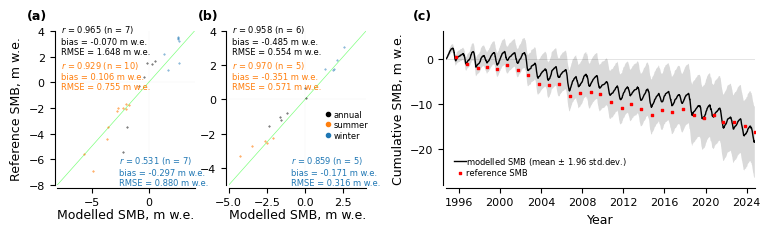

In [15]:
fig = plt.figure(figsize=(9, 2))

# Grid
gs = fig.add_gridspec(1, 4, wspace=0.7)
gs_sub1 = gs[0:, :2].subgridspec(1, 2, wspace=0.25)
gs_sub2 = gs[0:, 2:].subgridspec(2, 1)

# Axes
ax_t1 = fig.add_subplot(gs_sub1[0])
ax_t2 = fig.add_subplot(gs_sub1[1])
ax_t3 = fig.add_subplot(gs_sub2[:])


def make_scatter(ax, glacier, estimation_type, start_year=2019, end_year=2025, alpha_factor=2):
    # read x, y
    true_pred = {s: {"true": [], "pred": []} for s in ["annual", "winter", "summer"]}
    eval_path = f"eval/a_finetuned/{glacier['name']}.json"
    with open(eval_path, "r") as src:
        evaluation = json.load(src)
    for year in range(start_year, end_year):
        for s in ["annual", "winter", "summer"]:
            if str(year) in evaluation["true_pred"][estimation_type]["per_year"][s].keys():
                true_pred[s]["true"].extend(evaluation["true_pred"][estimation_type]["per_year"][s][str(year)]["true"])
                true_pred[s]["pred"].extend(evaluation["true_pred"][estimation_type]["per_year"][s][str(year)]["pred"])
    # make plot and labels
    # annual
    true, pred = np.array(true_pred["annual"]["true"]), np.array(true_pred["annual"]["pred"])
    if len(true) > 2:
        ax.scatter(pred, true, color="black", alpha=min(0.4 * alpha_factor, 1.0), zorder=-5, s=0.15, label="annual")
        r, _ = scipy.stats.pearsonr(pred, true)
        rmse = np.sqrt(np.mean((pred - true)**2))
        bias = np.mean(pred - true)
        report = f"$r$ = {r:.3f} (n = {len(true)}) \nbias = {bias:.3f} m w.e. \nRMSE = {rmse:.3f} m w.e."
        ax.text(0.025, 1.05, report, ha="left", va="top", transform=ax.transAxes, size=6, color="black", zorder=10)
    # winter
    true, pred = np.array(true_pred["winter"]["true"]), np.array(true_pred["winter"]["pred"])
    if len(true) > 2:
        ax.scatter(pred, true, color="C0", alpha=min(0.4 * alpha_factor, 1.0), zorder=-3, s=0.15, label="winter")
        r, _ = scipy.stats.pearsonr(pred, true)
        rmse = np.sqrt(np.mean((pred - true)**2))
        bias = np.mean(pred - true)
        report = f"$r$ = {r:.3f} (n = {len(true)}) \nbias = {bias:.3f} m w.e. \nRMSE = {rmse:.3f} m w.e."
        ax.text(0.45, 0.20, report, ha="left", va="top", transform=ax.transAxes, size=6, color="C0", zorder=10)
    # summer
    true, pred = np.array(true_pred["summer"]["true"]), np.array(true_pred["summer"]["pred"])
    if len(true) > 2:
        ax.scatter(pred, true, color="C1", alpha=min(0.6 * alpha_factor, 1.0), zorder=-4, s=0.15, label="summer")
        r, _ = scipy.stats.pearsonr(pred, true)
        rmse = np.sqrt(np.mean((pred - true)**2))
        bias = np.mean(pred - true)
        report = f"$r$ = {r:.3f} (n = {len(true)}) \nbias = {bias:.3f} m w.e. \nRMSE = {rmse:.3f} m w.e."
        ax.text(0.025, 0.82, report, ha="left", va="top", transform=ax.transAxes, size=6, color="C1", zorder=10)
        

make_scatter(ax_t1, glacier, "point")
make_scatter(ax_t2, glacier, "glacier-wide")


ax_t3.fill_between(time_vals, smb_trajectory - 1.96 * std_smb, smb_trajectory + 1.96 * std_smb, facecolor="black", edgecolor="none", alpha=0.15, zorder=-5)
ax_t3.plot(time_vals, smb_trajectory, color="black", linewidth=1.0, label="modelled SMB (mean $\\pm$ 1.96 std.dev.)")


# plot reference SMB if possible
total_smb = pandas.read_csv(f"{constants.data_folder}/{glacier['name']}/total_smb.csv")
total_smb = total_smb[total_smb.year >= constants.study_period_start_year]
if (total_smb["year"].diff().iloc[1:] == 1).all():
    ax_t3.scatter(pandas.to_datetime(total_smb["end_date"]), total_smb["annual_balance"].cumsum(), zorder=5, s=2, color="red", marker="s", label="reference SMB")
    

# labels and style
ax_t1.text(-0.25, 0.5, "Reference SMB, m w.e.", ha="right", va="center", transform=ax_t1.transAxes, size=9, rotation="vertical")
for ax in [ax_t1, ax_t2]:
    ax.text(0.5, -0.15, "Modelled SMB, m w.e.", ha="center", va="top", transform=ax.transAxes, size=9)


ax_t3.set_xlabel("Year", size=9)
ax_t3.set_ylabel("Cumulative SMB, m w.e.", size=9)


for i_ax, ax in enumerate([ax_t1, ax_t2, ax_t3]):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_position(("outward", 2))
    ax.spines["bottom"].set_position(("outward", 2))


for ax in [ax_t1, ax_t2]:
    ax.axline((0, 0), slope=1, color=[0.0, 1.0, 0.0, 0.5], zorder=-10, linewidth=0.5)
    ax.axvline(0, color=[0.0, 0.0, 0.0, 0.15], zorder=-15, linewidth=0.1)
    ax.axhline(0, color=[0.0, 0.0, 0.0, 0.15], zorder=-15, linewidth=0.1)
for ax in [ax_t3]:
    ax.axhline(0, color=[0.0, 0.0, 0.0, 0.15], zorder=-15, linewidth=0.5)

ax_t1.set_xlim(-8, 4)
ax_t1.set_ylim(-8, 4)
ax_t2.set_xlim(-5, 4)
ax_t2.set_ylim(-5, 4)
ax_t3.set_xlim(time_vals[0], time_vals[-1])

for ax in [ax_t1, ax_t2, ax_t3]:
    ax.tick_params(axis="both", labelsize=8)
for i_ax, ax in enumerate([ax_t1, ax_t2, ax_t3]):
    panel_label = f"({chr(ord('a') + i_ax)})"
    x, y = (-0.15, 1.1) if i_ax in {0, 1} else (-0.075, 1.1)
    ax.text(x, y, panel_label, weight="bold", ha="center", va="center", transform=ax.transAxes, size=9)

legend_handles = [matplotlib.lines.Line2D(
    [], [], 
    marker="o", 
    color=c, 
    linestyle="none",
    markersize=3,
    markerfacecolor=c,
    alpha=1.0,
) for c in ["black", "C1", "C0"]]
ax_t2.legend(handles=legend_handles, labels=["annual", "summer", "winter"], handletextpad=0.0, handlelength=1.5, labelspacing=0.2, frameon=False, fontsize=6, loc=(0.65, 0.27))
ax_t3.legend(handletextpad=0.0, handlelength=1.5, labelspacing=0.2, frameon=False, fontsize=6)

plt.savefig(f"figures/aleatoric_uq.pdf", dpi=300, bbox_inches="tight", pad_inches=0.02)
plt.show()